In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sciann as sn
from sciann.utils.math import diff, sign, sin
from gen_dataset import gen_grid
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

---------------------- SCIANN 0.6.3.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


## Part.1 数据集设置

In [2]:
Lx = 1.0
Ly = 1.0
T_Final = 0.5

NX = 40
NY = 40
NT = 20

EPOCHS = 2000
BATCH = 500

x_data, y_data, t_data = np.meshgrid(
    np.linspace(0, Lx, NX), 
    np.linspace(0, Ly, NY), 
    np.linspace(0, T_Final, NT)
)
x_data = x_data.reshape(-1, 1)
y_data = y_data.reshape(-1, 1)
t_data = t_data.reshape(-1, 1)

Lambd11 = np.pi * np.sqrt(2)
u_data = np.sin(np.pi * x_data) * np.sin(np.pi * y_data) * np.cos(Lambd11 * t_data)

## Part.2 无噪声数据驱动偏微分方程求解

In [3]:
x = sn.Variable('x', dtype='float64')
y = sn.Variable('y', dtype='float64')
t = sn.Variable('t', dtype='float64')
u = sn.Functional('u', [x, y, t], 4*[20], 'sin')

c = sn.Parameter(0.1, inputs=[x,y,t], name='c')

L1 = c * (diff(u, x, order=2) + diff(u, y, order=2)) - diff(u, t, order=2)

m = sn.SciModel(
    [x, y, t], 
    [sn.PDE(L1), sn.Data(u)],
    load_weights_from='membrane_inv_Noise-weights.hdf5'
)

inputs = [x_data, y_data, t_data]
targets = ['zeros', u_data] 

# m.load_weights('membrane_inv-weights.hdf5')

# h = m.train(
#     inputs, targets, 
#     batch_size=BATCH, 
#     learning_rate=0.001,
#     reduce_lr_after=50,
#     adaptive_weights={"method": "NTK", "freq": 100},
#     epochs=EPOCHS,
#     log_parameters={'parameters': c, 'freq':1}
# )

# m.save_weights('membrane_inv-weights.hdf5')


偏微分方程系数训练历史

In [4]:
# fig = plt.figure(figsize=(4,3))
# plt.semilogx(h.history['parameter_epochs'], np.concatenate(h.history['parameter_c']).flatten())
# plt.xlabel('epochs')
# plt.ylabel('$c$')
# plt.title('$c^* = 1.0$')
# plt.subplots_adjust(0.2,0.15,0.8,0.85)
# # plt.savefig('membrane_inv-results.png', dpi=300)
# plt.show()
parameters1 = 0.99985037

## Part.3 含噪声数据驱动偏微分方程求解

In [5]:
noise = 0.01
u_Noise_data = u_data + noise*np.std(u_data)*np.random.randn(u_data.shape[0])

inputs = [x_data, y_data, t_data]
targets = ['zeros', u_Noise_data] 

# m.load_weights('membrane_inv-weights.hdf5')

h = m.train(
    inputs, targets, 
    batch_size=BATCH, 
    learning_rate=0.001,
    reduce_lr_after=50,
    adaptive_weights={"method": "NTK", "freq": 100},
    epochs=EPOCHS,
    log_parameters={'parameters': c, 'freq':1}
)

# m.save_weights('membrane_inv_Noise-weights.hdf5')


Total samples: 32000 
Batch size: 500 
Total batches: 64 

139.52031207084656

+ adaptive_weights at epoch 1: [1.835389248141146, 0.16461075185885402]
Epoch 1/2000
64/64 [==============================] - 4s 59ms/step - loss: 2.0227e-06 - sub_loss: 7.5957e-08 - u_loss: 1.1441e-05
Epoch 2/2000
64/64 [==============================] - 1s 16ms/step - loss: 1.3084e-06 - sub_loss: 1.3822e-09 - u_loss: 7.9328e-06
Epoch 3/2000
64/64 [==============================] - 1s 17ms/step - loss: 1.3072e-06 - sub_loss: 1.0074e-09 - u_loss: 7.9299e-06
Epoch 4/2000
64/64 [==============================] - 1s 17ms/step - loss: 1.3200e-06 - sub_loss: 9.3612e-10 - u_loss: 8.0085e-06
Epoch 5/2000
64/64 [==============================] - 1s 17ms/step - loss: 1.3108e-06 - sub_loss: 1.1520e-09 - u_loss: 7.9501e-06
Epoch 6/2000
64/64 [==============================] - 1s 17ms/step - loss: 1.3401e-06 - sub_loss: 1.5613e-09 - u_loss: 8.1238e-06
Epoch 7/2000
64/64 [==============================] - 1s 17ms/step -

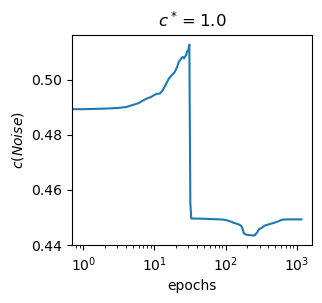

In [6]:
fig = plt.figure(figsize=(4,3))
plt.semilogx(h.history['parameter_epochs'], np.concatenate(h.history['parameter_c']).flatten())
plt.xlabel('epochs')
plt.ylabel('$c(Noise)$')
plt.title('$c^* = 1.0$')
plt.subplots_adjust(0.2,0.15,0.8,0.85)
plt.savefig('membrane_inv-Noise-results.png', dpi=300)
plt.show()
parameters2 = c.value

## Part.4 结果比较

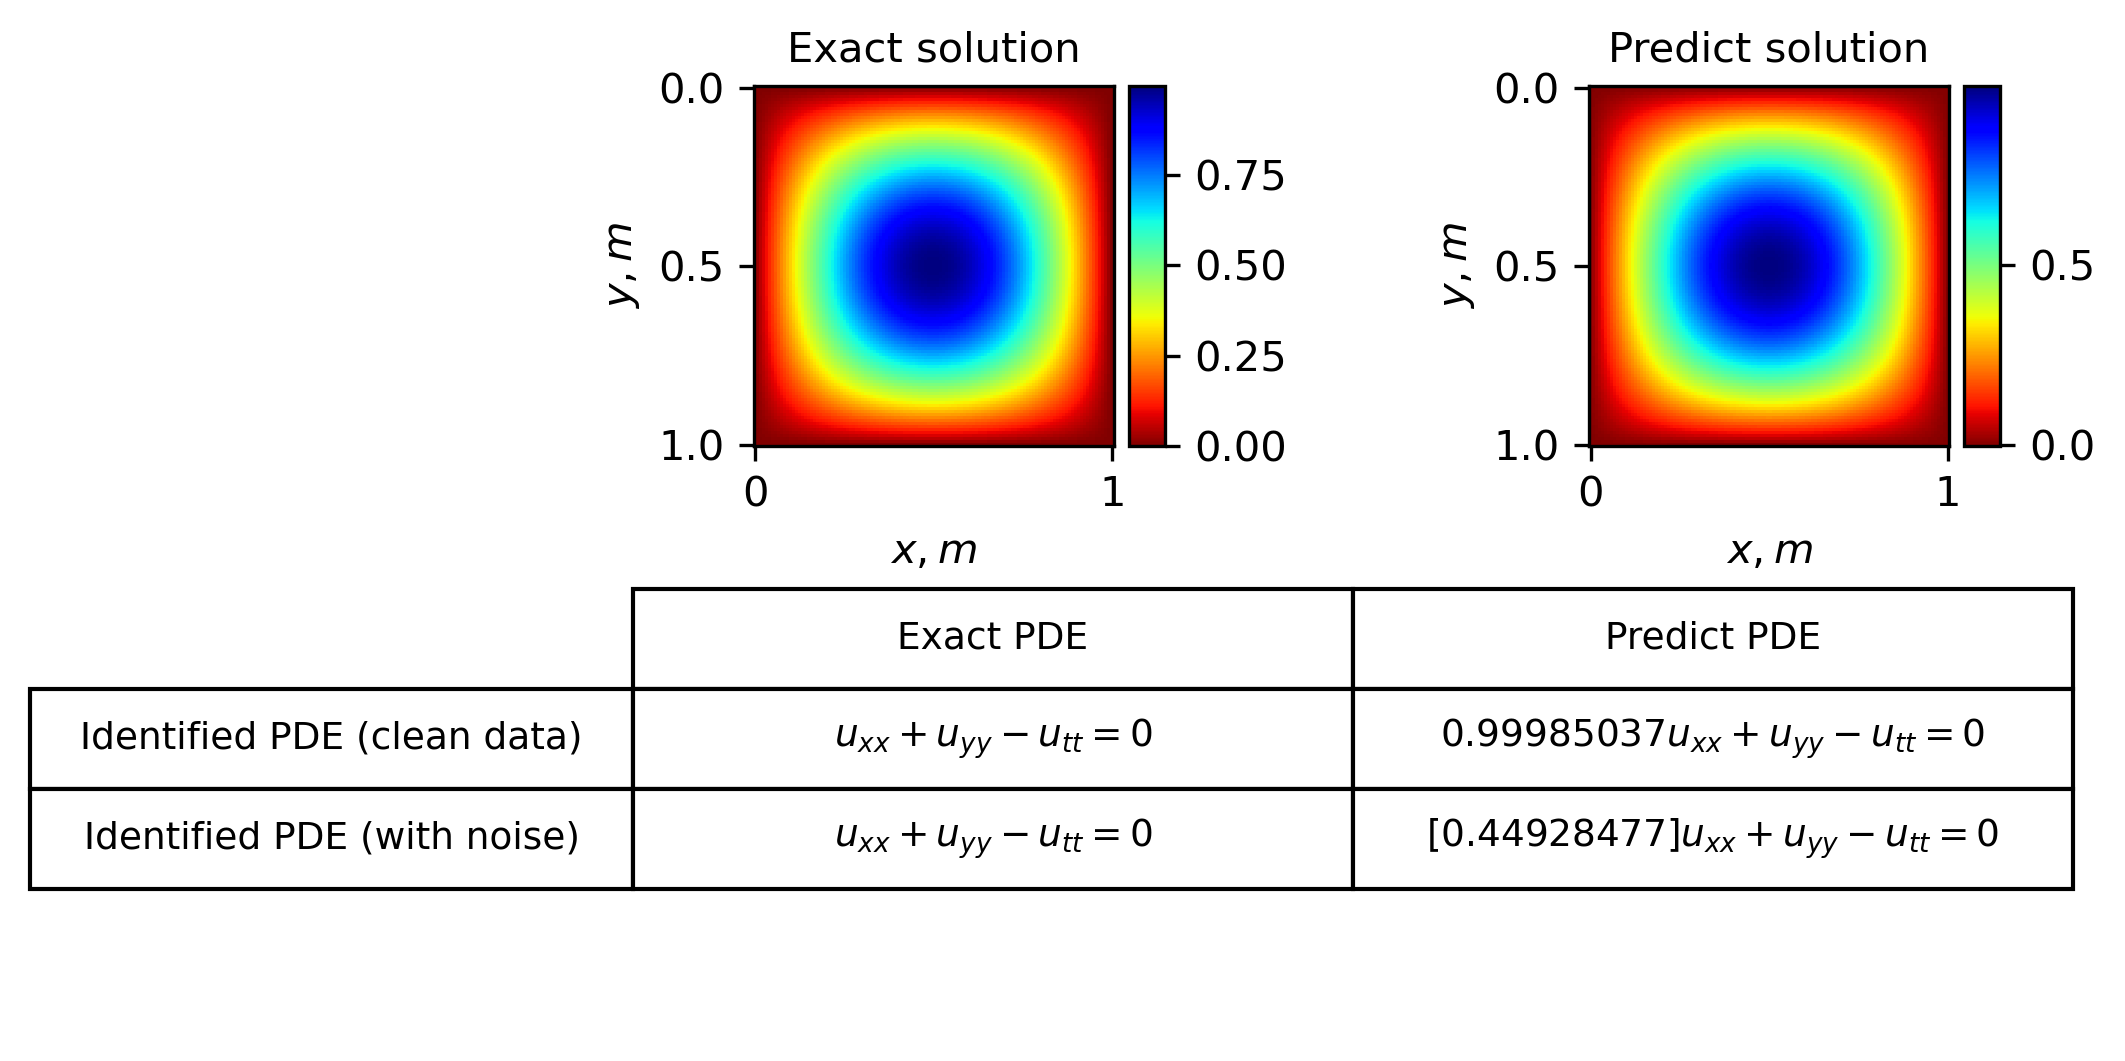

In [7]:

m.load_weights('membrane_inv-weights.hdf5')

x_test, y_test, t_test = np.meshgrid(
    np.linspace(0, Lx, NX*3), 
    np.linspace(0, Ly, NY*3), 
    np.linspace(0, T_Final, NT*3)
)

u_pred = u.eval(m, [x_test, y_test, t_test])

Lambd11 = np.pi * np.sqrt(2)
u_analytic = np.sin(np.pi * x_test) * np.sin(np.pi * y_test) * np.cos(Lambd11 * t_test)


t = 2
fig = plt.figure(figsize=(8, 3), dpi=300)
ax = plt.subplot(111)
ax.axis('off')
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=0.9, bottom=1-1/2, left=0.32, right=0.9, wspace=0.5)
## Row 1
# exact: Transmission Loss
ax = plt.subplot(gs1[:, 0])
ax.invert_yaxis()
h1 = ax.pcolormesh(x_test[:,:,0], y_test[:,:,0], u_analytic[:,:,t], cmap='jet_r', shading='auto')
divider = make_axes_locatable(ax)
cax2 = divider.append_axes("right", size="10%", pad=0.05)
fig.colorbar(h1, cax=cax2)
ax.set_xlabel('$x, m$')
ax.set_ylabel('$y, m$')
ax.set_aspect('equal', 'box')
ax.set_title('Exact solution', fontsize = 10)

# eval: Transmission Loss
ax = plt.subplot(gs1[:, 1])
ax.invert_yaxis()
h3 = ax.pcolormesh(x_test[:,:,0], y_test[:,:,0], u_pred[:,:,t], cmap='jet_r', shading='auto')
divider = make_axes_locatable(ax)
cax4 = divider.append_axes("right", size="10%", pad=0.05)
fig.colorbar(h3, cax=cax4)
ax.set_xlabel('$x, m$')
ax.set_ylabel('$y, m$')
ax.set_aspect('equal', 'box')
ax.set_title('Predict solution', fontsize = 10)

## Row2:  c * (diff(u, x, order=2) + diff(u, y, order=2)) - diff(u, t, order=2)
# Table
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=1-1/2, bottom=-0.15, left=0.3, right=0.9, wspace=0.5)
ax = plt.subplot(gs2[:, :])
ax.axis('off')
col = ['Exact PDE', 'Predict PDE']
row = ['Identified PDE (clean data)', 'Identified PDE (with noise)']
vals = [['$u_{xx}+u_{yy}-u_{tt}=0$', str(parameters1)+'$u_{xx}+u_{yy}-u_{tt}=0$'],
        ['$u_{xx}+u_{yy}-u_{tt}=0$', str(parameters2)+'$u_{xx}+u_{yy}-u_{tt}=0$']]
tab = plt.table(cellText=vals,
               colLabels=col,
               rowLabels=row,
               loc='center',
               cellLoc='center',
               rowLoc='center')
tab.scale(1,2)
plt.savefig('DatadrivedPDE.png',dpi=300)
plt.show()